<a href="https://colab.research.google.com/github/yujeonghyeop/Bitcoin-Anomaly-Transaction-Detection/blob/main/EDA%26tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import library 정의
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, precision_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve, roc_auc_score, fbeta_score, recall_score
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, f1_score, fbeta_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

%matplotlib inline
sns.set(style="whitegrid")
np.random.seed(203)


평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

In [ ]:
def anomalyScores(originalDF, reducedDF):
    loss = (np.array(originalDF) - np.array(reducedDF))**2
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    #print(loss)
    return loss

In [ ]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    print(preds)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])

    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [ ]:
# 5/8 추가 평가함수

def get_clf_eval(y_test, y_pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    F2 = fbeta_score(y_test, y_pred, beta=2.0) # beta가 1보다 크면 recall에 비중
    F0_5 = fbeta_score(y_test, y_pred, beta=0.5) # beta가 1보다 작으면 precision에 비중
    AUC = roc_auc_score(y_test, y_pred)

    print('Confusion Matrix : \n', confusion)
    print('\nAccuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('F2: {:.4f}'.format(F2))
    print('F0.5: {:.4f}'.format(F0_5))
    print('AUC: {:.4f}'.format(AUC))

    confusion_matrix_plot(confusion)

In [ ]:
# 5/8 추가 confusion matrix plot

def confusion_matrix_plot(cm):
    class_names = [0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y = 1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

특정 재현율 임계점별 정밀도를 평가하기 위한 새로운 함수 정의

In [ ]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

pandas로 데이터셋 읽어오기

In [ ]:
# 산점도 그래프 함수
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis =1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using " + algoName)



In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    


In [ ]:
raw_features = pd.read_csv("/content/drive/Shareddrives/bigdata_2022-1/elliptic_txs_features.csv")
raw_classes = pd.read_csv("/content/drive/Shareddrives/bigdata_2022-1/elliptic_txs_classes.csv")
raw_edgelist = pd.read_csv("/content/drive/Shareddrives/bigdata_2022-1/elliptic_txs_edgelist.csv")

In [ ]:
raw_classes['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [ ]:
print("feature : ", raw_features.shape)
print("classes : ", raw_classes.shape)
print("edgelist : ", raw_edgelist.shape)


feature :  (203768, 169)
classes :  (203769, 2)
edgelist :  (234355, 2)


In [ ]:
raw_features.isnull().sum()

230425980               0
1                       0
-0.1714692896288031     0
-0.18466755143291433    0
-1.2013688016765636     0
                       ..
-0.0874901561101501     0
-0.13115530389558736    0
-0.09752359377152515    0
-0.12061340670311574    0
-0.11979245961251665    0
Length: 167, dtype: int64

In [ ]:
raw_classes.isnull().sum()

txId     0
class    0
dtype: int64

In [ ]:
raw_edgelist.isnull().sum()

txId1    0
txId2    0
dtype: int64

In [ ]:
df_no_missing = raw_features.dropna(axis = 0)
df_no_missing = raw_features.dropna(axis = 1)
df_no_missing.shape

(203768, 167)

In [ ]:
df_no_missing2 = raw_classes.dropna(axis = 0)
df_no_missing2 = raw_classes.dropna(axis = 1)
df_no_missing2.shape

(203769, 2)

In [ ]:
df_no_missing3 = raw_edgelist.dropna(axis = 0)
df_no_missing3 = raw_edgelist.dropna(axis = 1)
df_no_missing3.shape

(234355, 2)

In [ ]:
# renaming columns

raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [ ]:
# trans = [f'trans_feat_{i}' for i in range(93)]
# agg = [f'agg_feat_{i}' for i in range(72)]

# for col in trans:
#   plt.boxplot(raw_features[col], labels=[col], showmeans=True)
#   plt.show()
# for col in agg:
#   plt.boxplot(raw_features[col], labels=[col], showmeans=True)
#   plt.show()

<BarContainer object of 3 artists>

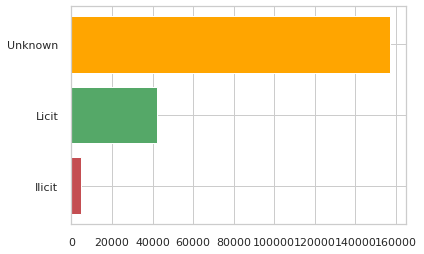

In [ ]:
raw_classes['class'].value_counts()
group_class = raw_classes.groupby('class').count()
plt.barh(['Ilicit', 'Licit', 'Unknown'], group_class['txId'].values, color=['r', 'g', 'orange'] )

Text(0.5, 1.0, 'Number of transactions in each time step')

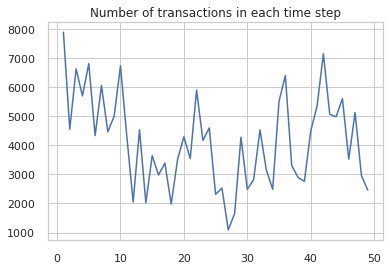

In [ ]:
raw_features['time'].value_counts().sort_index().plot();
plt.title('Number of transactions in each time step')

In [ ]:
# merge with classes

raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,txId,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,unknown
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,unknown
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,unknown
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,230459870,unknown


In [ ]:
#PCA 데이터 전처리 함수
def preprocessing(raw_data):

  raw_data.pop('time')
  raw_data.pop('txId')
  raw_data.pop("id")

  unknown_index = raw_data[raw_data['class'] == 'unknown'].index
  data_clean = raw_data.drop(unknown_index)

  data_clean['class'].replace({"1" : "1"}, inplace=True)
  data_clean['class'].replace({"2" : "0"}, inplace=True)
  data_clean['class'] = data_clean['class'].astype(float)

#상관관계 분석으로 Threshold(3%) 미만인 경우 삭제
  corr = data_clean.corr()
  corr_sort = abs(data_clean.corr()['class']).sort_values()
  corr_sort = corr_sort[corr_sort < 0.03]
  pdpd = pd.DataFrame(corr_sort)
  deletearray = pdpd.index
  for i in deletearray:
    data_clean.pop(i)
  

  #Class Feature을 제외한 나머지 Feature들 정규화 작업
  # std_data = preprocessing.StandardScaler().fit_transform(data.iloc[:, :-1])
  # std_data = pd.DataFrame(std_data, index = data.index, columns = data.columns[:-1])

  #Trans feature 따로 저장
  std_data_1 = data_clean.iloc[:,[k for k in range(60)]]

  #Agg Feature 따로 저장
  std_data_2 = data_clean.iloc[:,[k for k in range(60,103)]]

  #Trans Feature PCA 결과에 따라 20개의 주성분으로 압축
  pca_1 = PCA(n_components= 20)
  pca_1_array = pca_1.fit_transform(std_data_1)
  pca_1_df = pd.DataFrame(pca_1_array, index = std_data_1.index, columns = [f"pca{num+1}" for num in range(20)])

  #Agg Feature PCA 결과에 따라 25개의 주성분으로 압축
  pca_2 = PCA(n_components= 25)
  pca_2_array = pca_2.fit_transform(std_data_2)
  pca_2_df = pd.DataFrame(pca_2_array, index = std_data_2.index, columns = [f"pca{num+1}" for num in range(25)])

  #압축한 Trans Feature와 Agg Feature 합침
  realdata = pd.concat([pca_1_df,pca_2_df],axis=1)

  #위에서 합친 데이터에 Class Feature도 추가해줌.
  labeldata = pd.concat([realdata,data_clean['class']],axis=1)
  return labeldata


In [ ]:
def autoencoder(raw_data):
  
  raw_data.pop('time')
  raw_data.pop('txId')
  raw_data.pop("id")

  unknown_index = raw_data[raw_data['class'] == 'unknown'].index
  data_clean = raw_data.drop(unknown_index)

  adata = data_clean.copy()
  X = adata.drop(['class'], axis = 1).values
  Y = adata['class'].values

  input_layer = Input(shape=(X.shape[1],))

  encoded = Dense(100, activation='tanh', activity_regularizer = regularizers.l1(10e-5))(input_layer)
  encoded = Dense(50, activation='relu')(encoded)

  decoded = Dense(50, activation='tanh')(encoded)
  decoded = Dense(100, activation='tanh')(decoded)

  output_layer = Dense(X.shape[1], activation='relu')(decoded)

  autoencoder = Model(input_layer, output_layer)

  autoencoder.compile(optimizer="adadelta", loss="mse")
  x = adata.drop(["class"], axis = 1) 
  y = adata["class"].values

  x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
  x_normal = x_scale[y == '2']
  x_fraud = x_scale[y == '1']
  autoencoder.fit(x_normal, x_normal,batch_size = 256, epochs = 20,shuffle = True, validation_split = 0.20);

  hidden_representation = Sequential()
  hidden_representation.add(autoencoder.layers[0])
  hidden_representation.add(autoencoder.layers[1])
  hidden_representation.add(autoencoder.layers[2])

  norm_hid_rep = hidden_representation.predict(x_normal)
  fraud_hid_rep = hidden_representation.predict(x_fraud)
  rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)

  y_n = np.zeros(norm_hid_rep.shape[0]) 
  y_f = np.ones(fraud_hid_rep.shape[0])
  rep_y = np.append(y_n, y_f)

  autoencoder.summary()
  
  return rep_x, rep_y


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(15)

In [ ]:
labeldata = preprocessing(raw_features.copy())
X = labeldata.drop(['class'], axis=1)
y = labeldata['class']

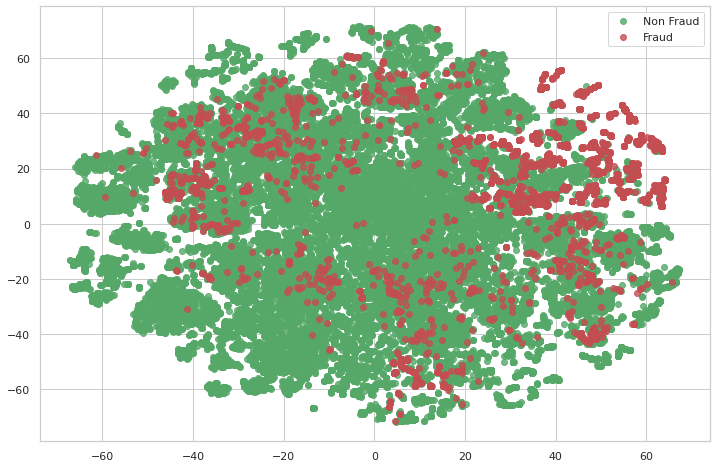

In [ ]:
tsne_plot(rep_X, rep_y, "original.png")    # PCA

In [ ]:
rep_X, rep_y = autoencoder(raw_features.copy())

Epoch 1/20
132/132 [==============================] - 3s 5ms/step - loss: 0.1422 - val_loss: 0.1517
Epoch 2/20
132/132 [==============================] - 1s 4ms/step - loss: 0.1409 - val_loss: 0.1503
Epoch 3/20
132/132 [==============================] - 1s 4ms/step - loss: 0.1397 - val_loss: 0.1489
Epoch 4/20
132/132 [==============================] - 1s 4ms/step - loss: 0.1384 - val_loss: 0.1475
Epoch 5/20
132/132 [==============================] - 1s 5ms/step - loss: 0.1372 - val_loss: 0.1461
Epoch 6/20
132/132 [==============================] - 0s 4ms/step - loss: 0.1359 - val_loss: 0.1447
Epoch 7/20
132/132 [==============================] - 1s 4ms/step - loss: 0.1347 - val_loss: 0.1434
Epoch 8/20
132/132 [==============================] - 0s 4ms/step - loss: 0.1335 - val_loss: 0.1421
Epoch 9/20
132/132 [==============================] - 1s 4ms/step - loss: 0.1323 - val_loss: 0.1408
Epoch 10/20
132/132 [==============================] - 1s 4ms/step - loss: 0.1311 - val_loss: 0.1395

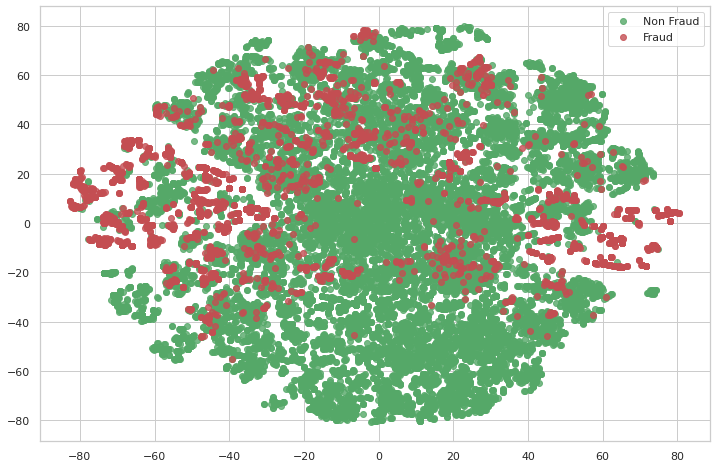

In [ ]:
#AutoEncoder

tsne_plot(rep_x, rep_y, "origin3.png")

In [ ]:
rep_X_train, rep_X_test, rep_y_train, rep_y_test = train_test_split(rep_X, rep_y, test_size=0.2, random_state = 13)

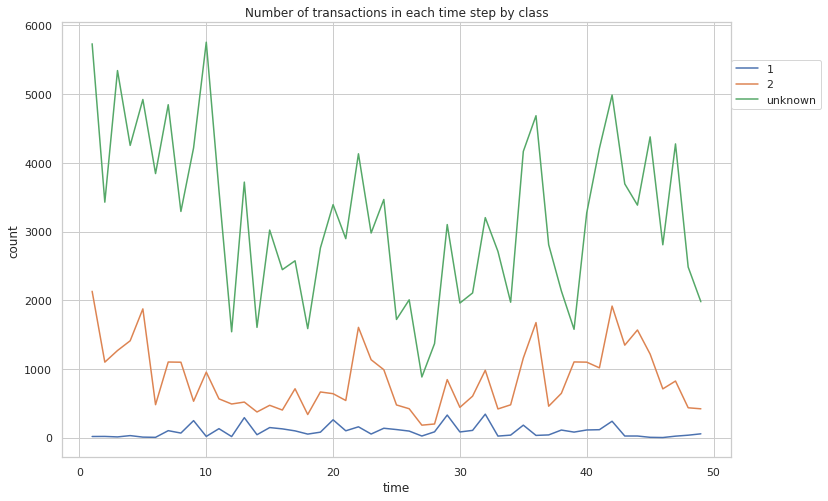

In [ ]:
plt.figure(figsize=(12,8))
grouped = raw_features.groupby(['time', 'class'])['id'].count().reset_index().rename(columns={'id' : 'count'})
sns.lineplot(x='time', y = 'count', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

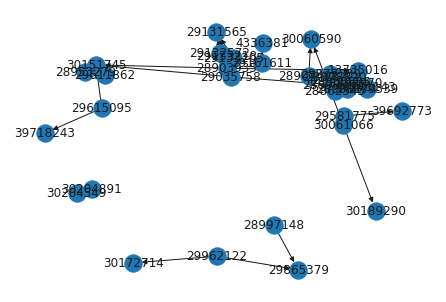

In [ ]:
#bad node(noise) visualization

bad_ids = raw_features.loc[(raw_features['time'] == 37) & (raw_features['class'] == '1'), 'id']
short_edges = raw_edgelist.loc[raw_edgelist['txId1'].isin(bad_ids)]
import networkx as nx

graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)